In [1]:
import os
path = 'C:/pytest/'
os.chdir(path)

In [2]:
def read_data(filename, encoding = 'cp949'):
    with open(filename, 'r', encoding= encoding) as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]
    return data
def write_data(data, filename, encoding = 'cp949'):
    with open(filename, 'w', encoding= encoding) as f:
        f.write(data)

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = read_data('ratings_morphed.txt', encoding = 'cp949')

In [5]:
import random
import math
random.shuffle(data)

part_num = math.floor(len(data) * 1/3)
data = data[:part_num]
print(len(data))

65853


In [6]:
data_text = [line[1] for line in data]
data_senti = [line[2] for line in data]

In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data_text, data_senti, stratify= data_senti)

In [8]:
from collections import Counter
train_y_freq = Counter(train_y)
test_y_freq = Counter(test_y)
print(train_y_freq, test_y_freq)

Counter({'0': 24728, '1': 24661}) Counter({'0': 8243, '1': 8221})


In [9]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 10000
maxlen = 20

In [10]:
tokenizer = Tokenizer(num_words= max_words)
tokenizer.fit_on_texts(train_X)
word_index = tokenizer.word_index

In [11]:
print(len(word_index), type(word_index), word_index)

23833 <class 'dict'> {'영화': 1, '하다': 2, '보다': 3, '없다': 4, 'ㅋㅋ': 5, '재미있다': 6, '좋다': 7, '너무': 8, '정말': 9, '있다': 10, '같다': 11, '진짜': 12, '되다': 13, '만들다': 14, '최고': 15, '연기': 16, '나오다': 17, '평점': 18, '다': 19, '이': 20, 'ㅋ': 21, '안': 22, '이런': 23, '잘': 24, '스토리': 25, '왜': 26, '드라마': 27, '알다': 28, '주다': 29, '때': 30, '더': 31, '사람': 32, '아깝다': 33, '내용': 34, '좀': 35, '감독': 36, '그냥': 37, '재미': 38, '지루하다': 39, '시간': 40, '말': 41, '재미없다': 42, 'ㅠㅠ': 43, '가다': 44, '감동': 45, '쓰레기': 46, '모르다': 47, '배우': 48, '처음': 49, '다시': 50, '작품': 51, '말다': 52, '아': 53, '생각': 54, '들다': 55, '그': 56, '마지막': 57, '액션': 58, '못하다': 59, '많다': 60, '완전': 61, '정도': 62, '느끼다': 63, '이렇게': 64, 'ㅎㅎ': 65, '못': 66, '돈': 67, '최악': 68, '생각하다': 69, '오다': 70, '별로': 71, '이야기': 72, '느낌': 73, '무슨': 74, '지금': 75, '사랑': 76, '보이다': 77, '쓰다': 78, '10점': 79, '끝': 80, '그리고': 81, '장면': 82, '참': 83, '명작': 84, '마음': 85, '괜찮다': 86, '역시': 87, '남다': 88, 'ㅡㅡ': 89, '많이': 90, '이것다': 91, 'ㅠ': 92, '또': 93, '좋아하다': 94, '한국': 95, '안되다': 96, '주인공': 97, '한': 9

In [12]:
# sequencing
train_X_sequencing = tokenizer.texts_to_sequences(train_X)

In [13]:
# padding
train_X_padding = pad_sequences(train_X_sequencing, maxlen= maxlen)

In [14]:
# 독립변수에 대해서 원-핫 인코딩을 할 필요가 없다.
labels = np.asarray(train_y).astype('float32')

In [34]:
labels

array([1., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [15]:
print(type(train_X),type(train_X_padding), train_X_padding.shape)
print(train_X_padding.ndim, labels.ndim)
print(train_X_padding.shape, labels.shape)

<class 'list'> <class 'numpy.ndarray'> (49389, 20)
2 1
(49389, 20) (49389,)


In [16]:
# validation data
validation_ratio = 0.3
validation_len = math.floor(len(train_X)*validation_ratio)

In [17]:
train_X = train_X_padding[validation_len:] # 70% 훈련
train_y = labels[validation_len:] # 70% 훈련 라벨
valid_X = train_X_padding[:validation_len] # 30% 검증
valid_y = labels[:validation_len] # 30% 검증 라벨

In [18]:
embedding_dim = 200

In [19]:
class_number =1
epochs = 5
batch_size = 32
model_name = 'text_binary_model.h5'
tokenizer_name = 'text_binary_tokenizer.pickle'

In [20]:
from keras.models import Sequential
from keras import layers
model = Sequential()
model.add(layers.Embedding(input_dim= max_words, output_dim= embedding_dim, input_length= maxlen))
# 3D : (batch_size, input_length(maxlen), feature_dim(embedding_dim))
model.add(layers.Flatten()) # input : 3D => output : 2D
model.add(layers.Dense(64, activation = 'relu')) # input : 2D => output : 2D
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(class_number, activation= 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           2000000   
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense (Dense)               (None, 64)                256064    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,258,177
Trainable params: 2,258,177
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer = 'rmsprop', loss= 'binary_crossentropy', metrics = ['acc'])
history = model.fit(train_X, train_y, epochs = epochs, batch_size = batch_size, validation_data= (valid_X, valid_y), verbose = 1)
history_dict = history.history

Epoch 1/5
1081/1081 [==============================] - 6s 4ms/step - loss: 0.4485 - acc: 0.7859 - val_loss: 0.4025 - val_acc: 0.8192
Epoch 2/5
1081/1081 [==============================] - 5s 4ms/step - loss: 0.3341 - acc: 0.8589 - val_loss: 0.4164 - val_acc: 0.8105
Epoch 3/5
1081/1081 [==============================] - 4s 4ms/step - loss: 0.2511 - acc: 0.8993 - val_loss: 0.4766 - val_acc: 0.8022
Epoch 4/5
1081/1081 [==============================] - 4s 4ms/step - loss: 0.1966 - acc: 0.9230 - val_loss: 0.5954 - val_acc: 0.7854
Epoch 5/5
1081/1081 [==============================] - 5s 4ms/step - loss: 0.1603 - acc: 0.9395 - val_loss: 0.7178 - val_acc: 0.7660


In [22]:
import pickle
model.save(model_name)

with open(tokenizer_name, 'wb') as f:
    pickle.dump(tokenizer, f, protocol = pickle.HIGHEST_PROTOCOL)

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss= history.history['val_loss']
epochs = range(1, len(val_acc) +1)

In [24]:
import matplotlib.pyplot as plt

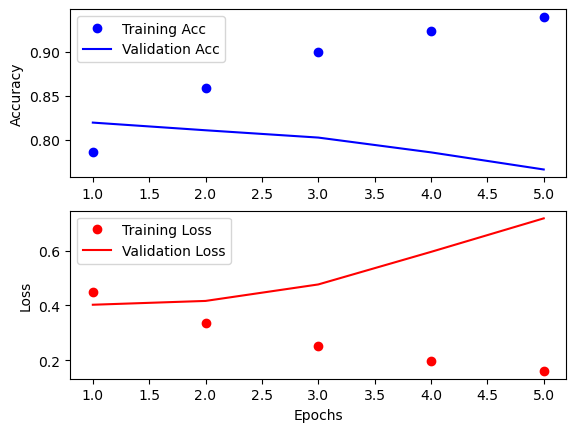

In [25]:
plt.subplot(211)
plt.plot(epochs, acc, 'bo', label = 'Training Acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation Acc')

plt.ylabel('Accuracy')
plt.legend()
plt.subplot(212)
plt.plot(epochs, loss, 'ro', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
from keras.models import load_model
loaded_model = load_model(model_name)
with open(tokenizer_name, 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [27]:
# sequencing
test_X_sequencing = loaded_tokenizer.texts_to_sequences(test_X)

In [28]:
# padding
test_X_padding = pad_sequences(test_X_sequencing, maxlen= maxlen)

In [29]:
# 원-핫 인코딩은 하지 않음
test_y = np.asarray(test_y).astype('float32')

In [30]:
# evaluation
test_eval = loaded_model.evaluate(test_X_padding, test_y)
test_eval

515/515 [==============================] - 1s 2ms/step - loss: 0.7344 - acc: 0.7706


[0.734350323677063, 0.7705903649330139]

In [32]:
import rhinoMorph
rn = rhinoMorph.startRhino()

filepath:  C:\Anaconda3\lib\site-packages
classpath:  C:\Anaconda3\lib\site-packages\rhinoMorph/lib/rhino.jar
RHINO started!


In [33]:
text = ['너무 지루해서 보다가 잤다.']
text = [rhinoMorph.onlyMorph_list(rn, sentence, pos = ['NNG','NNP','NP','VV','VA','XR','IC','MM','MAG','MAJ'], xrVv = True, eomi = True) for sentence in text]
print(text)

text_sequencing = loaded_tokenizer.texts_to_sequences(text)
text_padding = pad_sequences(text_sequencing, maxlen = maxlen)

prediction = loaded_model.predict(text_padding)
print(prediction)

[['너무', '지루하다', '자다']]
1/1 [==============================] - 0s 73ms/step
[[0.00493271]]
